## **Instalasi dan Import Library**



In [ ]:
# Install library yang diperlukan
!pip install newspaper3k nltk pandas lxml_html_clean imbalanced-learn matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import nltk
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from newspaper import Article
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Download resource bahasa
nltk.download('punkt')
nltk.download('punkt_tab')

print("✅ Instalasi dan Import Selesai!")

✅ Instalasi dan Import Selesai!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Kamus Lexicon Based untuk Labeling**

In [ ]:
# Kamus dan Cleaning

# kamus kata
lexicon_sumut = {
    # Skor -5
    'amblas': -5,
    'anaktirikan': -5,
    'biadab': -5,
    'fiktif': -5,
    'hancur': -5,
    'isolir': -5,
    'kupak-kapik': -5,
    'longsor': -5,
    'maut': -5,
    'mangkrak': -5,
    'mark-up': -5,
    'neraka': -5,
    'putus': -5,
    'suap': -5,
    'tewas': -5,

    # Skor -4
    'abaikan': -4,
    'amburadul': -4,
    'ancam': -4,
    'asal-asalan': -4,
    'bahaya': -4,
    'biarkan': -4,
    'darurat': -4,
    'kecelakaan': -4,
    'kubangan': -4,
    'memprihatinkan': -4,
    'palsu': -4,
    'parah': -4,
    'tutup mata': -4,
    'terbengkalai': -4,

    # Skor -3
    'becek': -3,
    'berlubang': -3,
    'debu': -3,
    'kecewa': -3,
    'kesal': -3,
    'lubang': -3,
    'lumpur': -3,
    'macet': -3,
    'mengeluh': -3,
    'retak': -3,
    'rusak': -3,
    'tagih': -3,
    'tuntut': -3,
    'terhambat': -3,
    'tipis': -3,
    'mengelupas': -3,
    'lalai': -3,
    'molor': -3,

    # Skor -2
    'debu': -2,
    'genangan': -2,
    'gelombang': -2,
    'janji': -2,
    'lambat': -2,
    'lelet': -2,
    'licin': -2,
    'ngadu': -2,
    'sulit': -2,
    'sulam': -2,
    'tambal': -2,
    'terganggu': -2,
    'viralkan': -2,

    # Skor -1
    'wacana': -1,

    # Skor 1
    'akan': 1,
    'anggaran': 1,
    'rencana': 1,
    'target': 1,
    'tinjau': 1,

    # Skor 2
    'evaluasi': 2,
    'kasih': 2,
    'perhatian': 2,
    'prioritas': 2,
    'teguran': 2,
    'terima': 2,

    # Skor 3
    'aspal': 3,
    'bangun': 3,
    'benahi': 3,
    'bantu': 3,
    'beton': 3,
    'gerak': 3,
    'instruksi': 3,
    'kerjakan': 3,
    'pembangunan': 3,
    'perbaikan': 3,
    'perbaiki': 3,
    'sidak': 3,
    'dukung': 3,
    'blacklist': 3,

    # Skor 4
    'bebas': 4,
    'hotmix': 4,
    'rampung': 4,
    'respon': 4,
    'selesai': 4,

    # Skor 5
    'apresiasi': 5,
    'kinclong': 5,
    'mantap': 5,
    'mulus': 5,
    'nyaman': 5,
}

# fungsi cleaning
def clean_text(text):
    text = str(text).lower().replace('\n', ' ')
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# fungsi scoring
def get_sentiment_score(text):
    skor = 0
    kata_kata = text.split()

    # Konteks tetap dipakai
    konteks_keluhan = ['jalan', 'lubang', 'rusak', 'warga', 'pengendara', 'truk', 'macet', 'air', 'banjir', 'lumpur', 'aspal', 'proyek', 'desa', 'kecamatan']

    for i, kata in enumerate(kata_kata):
        if kata in lexicon_sumut:
            nilai = lexicon_sumut[kata]
            if i > 0 and kata_kata[i-1] in ['tidak', 'bukan', 'belum', 'jangan', 'tak', 'gak']:
                nilai *= -1
            skor += nilai

    if skor >= 1:
        return "Positif"
    elif skor <= -1:
        return "Negatif"
    else:
        # Skor 0 (Netral Murni)
        # Kalau bahas jalan tapi skor 0, kemungkinan keluhan implisit -> Negatif
        if any(k in text for k in konteks_keluhan):
            return "Negatif"
        return "Netral"

print("Fungsi Scoring telah selesai!")

Fungsi Scoring telah selesai!


# **Scraping Data dan Auto Labeling**

In [ ]:
import requests
from newspaper import Article, Config
from nltk.tokenize import sent_tokenize
import time
import random
import pandas as pd
import re
import os

# konfigurasi penyamaran
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Referer': 'https://www.google.com/',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1'
}

# daftar link berita
urls_berita = [
    "https://www.detik.com/sumut/berita/d-8031956/viral-warga-protes-dengan-mancing-di-jalan-rusak-pemkab-deli-serdang-sabar",
    "https://www.detik.com/sumut/berita/d-8131179/sudah-rusak-puluhan-tahun-perbaikan-jalan-labura-toba-dikerjakan-tahun-ini",
    "https://sumut.antaranews.com/berita/615605/gubernur-sumut-perbaiki-jalan-rusak-gunungsitoli-nias-utara",
    "https://www.detik.com/sumut/berita/d-8220013/jalan-pelita-vi-medan-banyak-lubang-warga-kesal-kendaraan-jadi-cepat-rusak/amp",
    "https://medan.viva.co.id/medan/9109-ini-lima-jalan-rusak-berat-yang-segera-diperbaiki-pemko-medan",
    "https://www.waspada.id/medan/jalan-sunggal-rusak-parah-seperti-kubangan-kerbau-warga-menangis/",
    "https://daerah.sindonews.com/read/1615231/174/respons-aduan-warga-legislator-partai-perindo-binsar-simarmata-dorong-pemkot-medan-benahi-jalan-dan-bangun-drainase-1756868971/5",
    "https://www.detik.com/sumut/berita/d-7883242/jalan-di-paluta-tapsel-20-tahun-rusak-parah-warga-ngadu-ke-bobby-nasution",
    "https://nasional.tvrinews.com/berita/tdbrjkg-warga-kepulauan-nias-desak-pemprov-sumut-segera-perbaiki-jalan-rusak",
    "https://www.metrotvnews.com/read/koGCd2JA-jalan-rusak-30-tahun-pertumbuhan-ekonomi-dolok-paluta-terhambat",
    "https://www.rubis.id/2025/04/21/kesal-anggota-dprd-minta-pemko-medan-perbaiki-jalan-rusak-akses-pasar-induk-lau-chi",
    "https://www.waspada.id/aceh/rusak-parah-jalan-lintas-nasional-warnai-kabupaten-karo-dairi-dan-pakpak-bharat/",
    "https://www.antaranews.com/berita/5136505/gubernur-sumut-targetkan-ruas-jalan-labura-toba-diperbaiki-tahun-ini",
    "https://www.waspada.id/medan/warga-keluhkan-jalan-rusak-berlobang-di-harjosari-i/",
    "https://www.detik.com/sumut/berita/d-8224501/lapor-pak-wali-ada-lubang-besar-di-jalan-karya-bakti-medan-bahayakan-pengendara",
    "https://sumut.idntimes.com/news/sumatera-utara/15-tahun-rusak-jalan-bahorok-mulai-diperbaiki-2026-00-f4z9n-s10xlc",
    "https://medan.kompas.com/read/2025/11/26/161741378/banjir-dan-longsor-di-tapanuli-selatan-akses-jalan-nasional-putus-dan-lumpuh",
    "https://www.detik.com/sumut/berita/d-8228500/jalan-sidorukun-rusak-camat-medan-timur-sudah-disurati-ke-upt-sdabmbk",
    "https://www.sumatera24jam.com/2025/10/1000-km-jalan-simalungun-rusak-warga.html",
    "https://www.detik.com/sumut/berita/d-8068036/pemprov-sumut-anggarkan-rp-165-miliar-untuk-perbaiki-6-jalan-di-nias",
    "https://web.simalungunkab.go.id/2025/10/24/tinjau-jalan-provinsi-putus-akibat-longsor-bupati-simalungun-perintahkan-kadis-putr-l",
    "https://www.waspada.id/sumut/jalan-provinsi-ruas-gunungsitoli-menuju-nias-barat-terancam-putus/",
    "https://www.sinata.id/jalan-rusak-parah-di-ujung-purba-simalungun-dikeluhkan-warga/",
    "https://www.detik.com/sumut/berita/d-8178422/jalan-rusak-bikin-warga-di-asahan-terpaksa-gotong-jenazah-menuju-rumah-duka",
    "https://agaranews.com/2025/11/25/sinergi-tni-aparat-dan-warga-jalan-rusak-di-barusjahe-ditimbun-bersama/",
    "https://medanbisnisdaily.com/news/online/read/2025/11/19/194940/jalan_penghubung_sergai_tebing_tinggi_rusak_parah_warga_batu_12_",
    "https://www.waspada.id/sumut/jalan-rusak-panyabungan-warga-desak-bupati-madina-bertindak/",
    "https://www.sinata.id/5-tahun-warga-keluhkan-jalan-rusak-dekat-rumah-dinas-wakil-wali-kota-siantar/",
    "https://sumut.suara.com/read/2025/04/25/153613/puluhan-tahun-rusak-bobby-nasution-target-perbaiki-jalan-3-kabupaten-tahun-ini",
    "http://medan.kompas.com/read/2025/11/28/181329878/jalan-tol-medan-kualanamu-tebing-tinggi-amblas-jasa-marga-beri-penjelasan",
    "https://medanbisnisdaily.com/news/online/read/2025/11/28/195218/jalan_menuju_kantor_camat_tanjung_beringin_dan_kantor_bupati_ser",
    "https://www.metro-online.co/2025/11/jalan-di-desa-bandar-klippa-kecamatan-percut-seituan-masih-dilanda-banjir.html",
    "https://www.tempo.co/politik/jalan-di-tapanuli-tengah-rusak-imbas-bencana-distribusi-bantuan-dikirim-via-jalur-udara-2093873",
    "https://www.detik.com/sumut/berita/d-8230486/jalinsum-penghubung-pakkat-dolok-sanggul-humbahas-putus-total-akibat-banjir",
    "http://medan.kompas.com/read/2025/11/27/171209778/jalan-binjai-medan-lumpuh-diterjang-banjir-pengendara-motor-dialihkan-lewat",
    "https://www.taslabnews.com/2025/06/percepat-perbaikan-infrastruktur-wali-kota-tanjungbalai-datangi-dirjen-bina-marga-kementerian",
    "https://deteksi.co/pengaspalan-jalan-desa-pegagan-julu-vii-dairi-rusak-dalam-hitungan-hari/",
    "https://www.cnews.web.id/2025/09/jalan-rusak-sepanjang-2-km-di-dusun-5.html",
    "https://kowarnews.co.id/tahun-2025-plt-bupati-palas-minta-perbaikan-peningkatan-jalinsum-tetap-jadi-perhatian-pemprov-sumut/",
    "https://www.mimbarsumut.com/ragam/jalan-rusak-parah-di-desa-sarahili-nias-selatan-warga-bertaruh-nyawa-demi-aktivitas-sehari-har",
    "https://sumut.antaranews.com/berita/646541/bpbd-sumut-13-korban-meninggal-akibat-bencana-hidrometeorologi",
    "https://sumut.antaranews.com/berita/641681/dinas-putr-samosir-gerak-cepat-tangani-ambles-di-jembatan-siriaon-pendistribusian-mbg",
    "https://sumut.antaranews.com/berita/646541/bpbd-sumut-13-korban-meninggal-akibat-bencana-hidrometeorologi",
    "https://deteksi.co/pembangunan-properti-jewel-garden-di-sampali-dinilai-abaikan-keselamatan-warga-jalan-rusak-dan-kecelakaan-ter",
    "https://www.88news.id/2025/10/acai-sembada-perbaiki-20-titik-jalan.html",
    "https://www.waspada.id/sumut/tebing-runtuh-putuskan-akses-jalan-padangsidimpuan-ke-kota-medan/",
    "https://www.detik.com/sumut/berita/d-8223190/pemkot-medan-soal-jalan-rusak-di-simpang-kantor-segera-diperbaiki",
    "https://infotrafficid.com/jalan-rusak-simpang-kantor-medan-labuhan-nasional/",
    "https://www.rmolsumut.id/jalan-rusak-di-medan-marelan-akhirnya-diperbaiki-pekan-depan-mulai-dikerjakan",
    "https://www.bidikkasusnews.com/2025/08/jalan-secanggangstabat-rusak-juga.html",
    "https://metroekspress.com/11/09/2025/berita-sumut/ekspos-langkat/jalan-rusak-4-km-dari-stabat-secanggang-rugikan-warga-aktivis-desak-pemerintah-segera-bertindak/",
    "https://www.langkatkab.go.id/berita/5462/syah-afandin-tinjau-jalan-rusak-di-stabat-dan-secanggang-pastikan-perbaikan-dimulai-okt",
    "https://www.sinarsumutnews.com/2025/08/proses-lelang-proyek-jalan-provinsi.html",
    "https://www.waspada.id/sumut/jalan-rusak-panyabungan-warga-desak-bupati-madina-bertindak/",
    "https://diskominfo.madina.go.id/jalan-menuju-objek-wisata-di-madina-rusak/",
    "https://diskominfo.madina.go.id/waspada-banyak-titik-jalan-longsor-di-panyabungan-selatan/",
    "https://simantab.com/perbaikan-jalan-viyata-yudha-dilakukan-akhir-tahun-warga-pertanyakan-kualitas-dan-koordinasi-antarinstansi/",
    "https://www.sbnpro.com/alex-damanik-gelar-reses-di-siantar-marihat-warga-keluhkan-drainase-dan-jalan-rusak/",
    "https://analisadaily.com/berita/arsip/2014/9/1/59714/jalan-provinsi-di-batubara-semakin-parah/",
    "https://bataratv.com/belum-setahun-dikerjakan-proyek-jembatan-sidalu-dalu-cinta-damai-indrapura-berlubang-menunggu-korban-kecelakaan/",
    "https://tribratanews.resbatubara.sumut.polri.go.id/kapolsek-indrapura-pimpin-gotong-royong-pasca-banjir-warga-dan-pemerintah-desa-bersatu/",
    "https://www.digtara.com/nusantara/76362/jalan-rusak-dan-berlubang-resahkan-pengendara-di-tebing-tinggi/",
    "https://bongkarnews.com/baru-setahun-peningkatan-ruas-jalan-rambutan-kecamatan-tebing-tinggi-sudah-rusak/",
    "https://medan.kompas.com/read/2025/11/28/164813978/jalan-tol-tebing-tinggi-medan-amblas-lalu-lintas-dialihkan"
]

data_final = []
print(f"gaspol scraping {len(urls_berita)} link berita...")

for url in urls_berita:
    try:
        response = requests.get(url, headers=headers, timeout=20)

        if response.status_code == 200:
            article = Article(url)
            article.download(input_html=response.text) # Pake HTML yang kita ambil sendiri
            article.parse()

            kalimat_list = sent_tokenize(article.text)

            for kalimat in kalimat_list:
                teks_bersih = clean_text(kalimat)
                if len(teks_bersih.split()) < 3: continue

                label = get_sentiment_score(teks_bersih)
                data_final.append({'Sumber': 'Berita', 'Teks': teks_bersih, 'Label': label})

            print(f"[V] Sukses: {url[:35]}... (+{len(kalimat_list)} kalimat)")
        else:
            print(f"[X] Masih diblokir (Status {response.status_code}): {url[:35]}...")

        # Jeda acak biar ga mencurigakan
        time.sleep(random.uniform(2, 4))

    except Exception as e:
        print(f"[!] Error teknis di {url[:30]}: {str(e)[:50]}")

# simpan hasilnya
df = pd.DataFrame(data_final)
df.to_csv("dataset_siap_olah.csv", index=False)
print(f"\nTotal Data Final: {len(df)}")
print(df['Label'].value_counts())

gaspol scraping 64 link berita...
[V] Sukses: https://www.detik.com/sumut/berita/... (+27 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+13 kalimat)
[V] Sukses: https://sumut.antaranews.com/berita... (+0 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+20 kalimat)
[V] Sukses: https://medan.viva.co.id/medan/9109... (+17 kalimat)
[V] Sukses: https://www.waspada.id/medan/jalan-... (+28 kalimat)
[V] Sukses: https://daerah.sindonews.com/read/1... (+6 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+18 kalimat)
[V] Sukses: https://nasional.tvrinews.com/berit... (+19 kalimat)
[V] Sukses: https://www.metrotvnews.com/read/ko... (+14 kalimat)
[V] Sukses: https://www.rubis.id/2025/04/21/kes... (+21 kalimat)
[V] Sukses: https://www.waspada.id/aceh/rusak-p... (+23 kalimat)
[V] Sukses: https://www.antaranews.com/berita/5... (+20 kalimat)
[V] Sukses: https://www.waspada.id/medan/warga-... (+19 kalimat)
[V] Sukses: https://www.detik.com/sumut/berita/... (+15 ka

# **Visualisasi Hasil Scraping Data (Awal)**

ini rincian jumlah datanya:
Label
Negatif    532
Netral     169
Positif    152
Name: count, dtype: int64


/tmp/ipython-input-151459264.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label', data=df_vis, palette='viridis', order=['Negatif', 'Netral', 'Positif'])


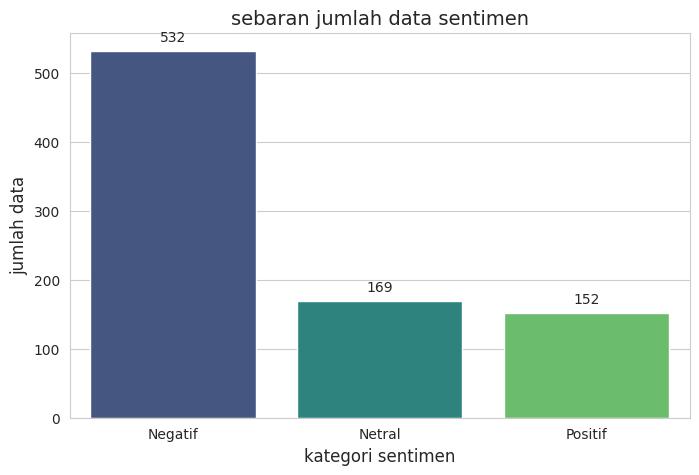

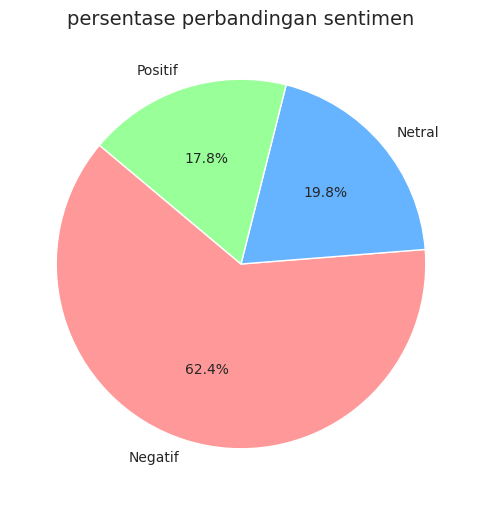

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# baca file csv yang barusan dibuat
df_vis = pd.read_csv("dataset_siap_olah.csv")

# cek dulu angkanya di layar
print("ini rincian jumlah datanya:")
print(df_vis['Label'].value_counts())

# atur gaya gambar biar agak bagusan dikit
sns.set_style("whitegrid")

# - bikin diagram batang
plt.figure(figsize=(8, 5))
# urutan labelnya kita set biar rapi: negatif, netral, positif
ax = sns.countplot(x='Label', data=df_vis, palette='viridis', order=['Negatif', 'Netral', 'Positif'])

# kasih angka di atas diagram batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

plt.title('sebaran jumlah data sentimen', fontsize=14)
plt.xlabel('kategori sentimen', fontsize=12)
plt.ylabel('jumlah data', fontsize=12)
plt.show()

# bikin diagram lingkaran buat liat porsi persentasenya
plt.figure(figsize=(6, 6))
counts = df_vis['Label'].value_counts()
warna = ['#ff9999', '#66b3ff', '#99ff99'] # warna pastel biar mata ga sakit

plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=warna)
plt.title('persentase perbandingan sentimen', fontsize=14)
plt.show()

# **Wordcloud**

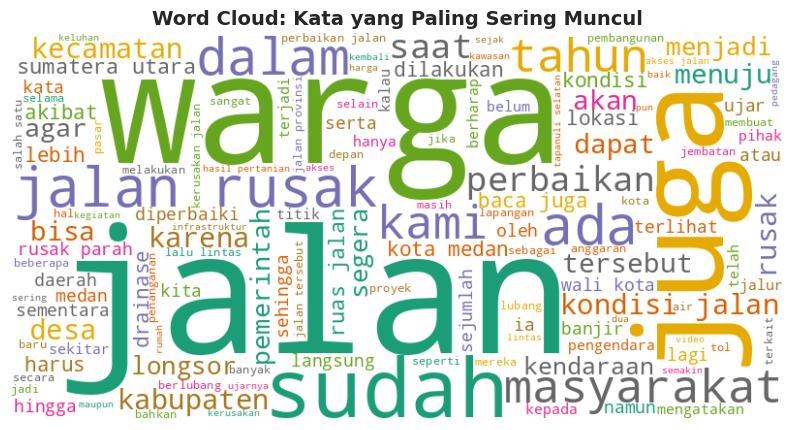

In [ ]:
# Install Library WordCloud
!pip install wordcloud

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Wordcloud
# Gabungkan semua teks jadi satu string besar
all_text = ' '.join(df['Teks'].astype(str).tolist())

# List stopword sederhana biar wordcloud bersih
stopwords_id = set(['yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'untuk', 'pada', 'adalah', 'dengan', 'saya', 'aku', 'tidak', 'yg', 'kalo', 'nya'])

# Buat WordCloud
wc = WordCloud(width=800, height=400,
               background_color='white',
               stopwords=stopwords_id,
               min_font_size=10,
               colormap='Dark2').generate(all_text)

# show
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off") # Hilangkan sumbu x/y
plt.title('Word Cloud: Kata yang Paling Sering Muncul', fontsize=14, fontweight='bold')
plt.show()

# **Preprocessing dan SMOTE**

In [ ]:
# Load Data
X_raw = df['Teks'].astype(str)
y_raw = df['Label']

# Ubah Teks jadi Angka (TF-IDF) - Term Frequency-Invers Document Frequency
print("lagi mengubah teks jadi angka...")
tfidf = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf.fit_transform(X_raw)

# split data sebelum SMOTE
# Kita pisahkan data ujian (Test) yang murni (sesuai fakta lapangan)
print("\nlagi membagi data latih dan uji...")
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

print(f"jumlah data latih asli: {X_train.shape[0]}")
print(f"jumlah data uji murni : {X_test.shape[0]}")

# penerapan SMOTE pada data latih saja
# Biar model belajarnya seimbang, tapi ujiannya tetep realita
print("\nlagi menyeimbangkan data latih pake smote...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("distribusi data latih setelah smote:")
print(y_train_resampled.value_counts())

lagi mengubah teks jadi angka...

lagi membagi data latih dan uji...
jumlah data latih asli: 682
jumlah data uji murni : 171

lagi menyeimbangkan data latih pake smote...
distribusi data latih setelah smote:
Label
Negatif    425
Positif    425
Netral     425
Name: count, dtype: int64


# **Visualisasi Hasil SMOTE**



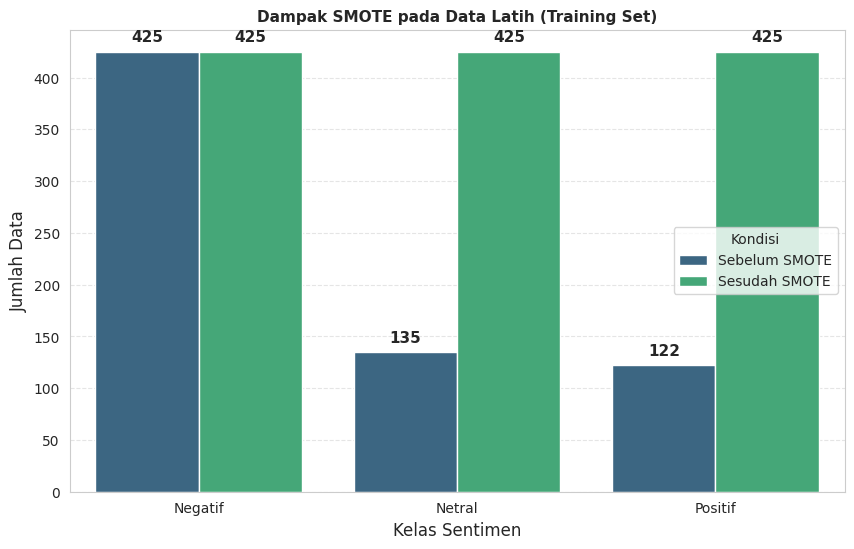

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# set data untuk plot
try:
    counts_before = y_train.value_counts().sort_index()
    counts_after = pd.Series(y_train_resampled).value_counts().sort_index()

    # Buat DataFrame untuk Seaborn
    df_visual = pd.DataFrame({
        'Sentimen': counts_before.index.tolist() + counts_after.index.tolist(),
        'Jumlah': counts_before.values.tolist() + counts_after.values.tolist(),
        'Kondisi': ['Sebelum SMOTE'] * len(counts_before) + ['Sesudah SMOTE'] * len(counts_after)
    })

    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df_visual, x='Sentimen', y='Jumlah', hue='Kondisi', palette='viridis')

    # Tambahkan Angka di Atas Batang
    for p in ax.patches:
        if p.get_height() > 0: # Cek agar tidak error pada data kosong
            height = int(p.get_height())
            ax.annotate(f'{height}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        xytext=(0, 5), textcoords='offset points',
                        fontsize=11, fontweight='bold')

    plt.title('Dampak SMOTE pada Data Latih (Training Set)', fontsize=11, fontweight='bold')
    plt.xlabel('Kelas Sentimen', fontsize=12)
    plt.ylabel('Jumlah Data', fontsize=12)
    plt.legend(title='Kondisi')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

except NameError:
    print("⚠️ Variabel tidak ditemukan")

# **Hasil Akurasi Model dan Confusion Matrix (Evaluasi)**

lagi training model...
model selesai dilatih!

--- Hasil Evaluasi Model (Pada Data Uji) ---
Akurasi: 73.10%

Detail Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.89      0.77      0.82       107
      Netral       0.67      0.65      0.66        34
     Positif       0.46      0.70      0.55        30

    accuracy                           0.73       171
   macro avg       0.67      0.70      0.68       171
weighted avg       0.77      0.73      0.74       171



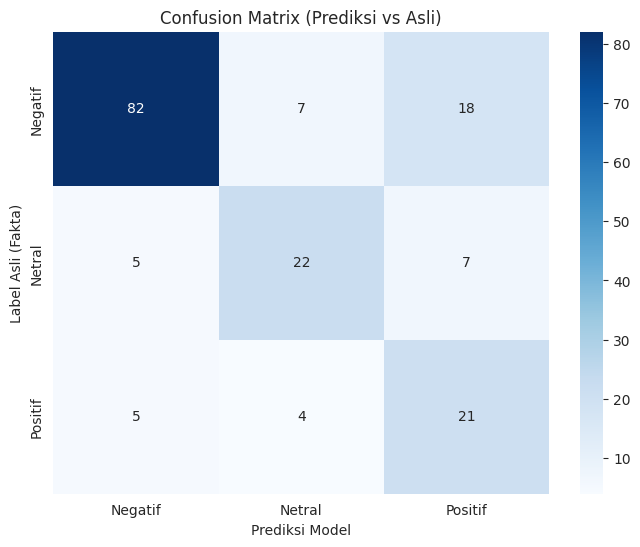

In [ ]:
# Training Model Naive Bayes
print("lagi training model...")
model_nb = MultinomialNB()
model_nb.fit(X_train_resampled, y_train_resampled)
print("model selesai dilatih!")

# Prediksi ke Data Uji
y_pred = model_nb.predict(X_test)

# Tampilkan Hasil Evaluasi
print("\n--- Hasil Evaluasi Model (Pada Data Uji) ---")
print(f"Akurasi: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nDetail Klasifikasi:")
print(classification_report(y_test, y_pred))

# Gambar Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model_nb.classes_, yticklabels=model_nb.classes_)
plt.title('Confusion Matrix (Prediksi vs Asli)')
plt.ylabel('Label Asli (Fakta)')
plt.xlabel('Prediksi Model')
plt.show()

# **Hasil Prediksi Data Uji**


--- Ringkasan Hasil Prediksi (Data Uji) ---
         Jumlah (Data) Persentase (%)
Negatif             92          53.8%
Netral              33          19.3%
Positif             46          26.9%
Total Data Uji: 171


/tmp/ipython-input-2250867257.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=jumlah_per_label.values, palette=colors)


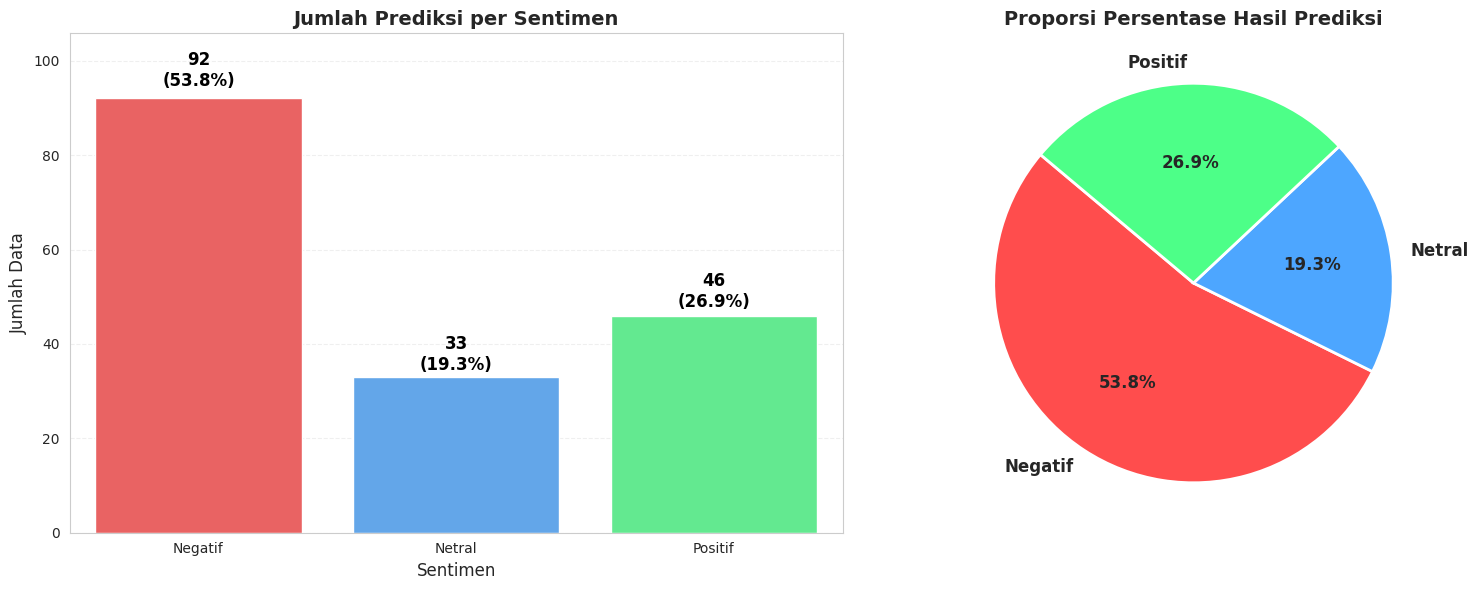

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# model memprediksi  biar variabel 'y_pred' ada isinya
y_pred = model_nb.predict(X_test)

# siapkan data (angka dan persen)
# Ambil hasil prediksi dari model
data_prediksi = pd.Series(y_pred)
jumlah_per_label = data_prediksi.value_counts().sort_index()
total_data = len(data_prediksi)

# Hitung persentase manual biar akurat
persentase = (jumlah_per_label / total_data) * 100

# Buat DataFrame ringkasan (buat diprint teks juga)
df_ringkasan = pd.DataFrame({
    'Jumlah (Data)': jumlah_per_label,
    'Persentase (%)': persentase.map('{:.1f}%'.format)
})

print("\n--- Ringkasan Hasil Prediksi (Data Uji) ---")
print(df_ringkasan)
print(f"Total Data Uji: {total_data}")

# Buat grafik visualisasi
plt.figure(figsize=(16, 6)) # Ukuran lebar kanvas

# Grafik Batang
plt.subplot(1, 2, 1) # Posisi kiri
urutan_warna = ['#ff4d4d', '#4da6ff', '#4dff88'] # Merah, Biru, Hijau
# Pastikan urutan warna sesuai label yg muncul (Negatif, Netral, Positif)
labels = jumlah_per_label.index.tolist()
colors = [urutan_warna[i] if i < len(urutan_warna) else '#333333' for i in range(len(labels))]

ax = sns.barplot(x=labels, y=jumlah_per_label.values, palette=colors)

# Loop untuk nambahin Teks (Angka + Persen) di atas batang
for i, p in enumerate(ax.patches):
    height = p.get_height()
    # Ambil data sesuai urutan
    label_text = f"{int(height)}\n({persentase.iloc[i]:.1f}%)"

    ax.text(p.get_x() + p.get_width() / 2., height + (height*0.02),
            label_text,
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title('Jumlah Prediksi per Sentimen', fontsize=14, fontweight='bold')
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.ylim(0, max(jumlah_per_label.values) * 1.15) # Kasih jarak atas biar teks ga kepotong
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Grafik Lingkaran
plt.subplot(1, 2, 2) # Posisi kanan
plt.pie(jumlah_per_label, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})

plt.title('Proporsi Persentase Hasil Prediksi', fontsize=14, fontweight='bold')

# Tampilkan ke display
plt.tight_layout()
plt.show()

# **Perbandingan Model Naive Bayes dan Lexicon-Based**

In [ ]:
# @title
# prepare data wasit buat diuji manual
# ini contoh kalimat yang kita labeli sendiri pake logika manusia (kunci jawaban)
data_uji_manual = [
    # kalimat ---------------------------------------------------- label asli (manual)
    ("jalan di kampung kami hancur lebur kayak kubangan kerbau",   "Negatif"),
    ("terima kasih pak bupati jalan sudah mulus mantap",           "Positif"),
    ("proyek ini mangkrak anggarannya dikorupsi pejabat",          "Negatif"),
    ("pemerintah akan menganggarkan dana perbaikan tahun depan",   "Positif"), # lexicon mungkin salah disini
    ("debu jalanan sangat mengganggu pernapasan warga",            "Negatif"),
    ("respon dinas pu sangat lambat padahal sudah viral",          "Negatif"),
    ("akhirnya jalan ini diaspal juga setelah sekian lama",        "Positif"),
    ("hati hati lewat sini banyak lubang dalam bahaya",            "Negatif"),
    ("cuma janji palsu perbaikan gak pernah ada realisasi",        "Negatif"),
    ("alhamdulillah akses ke pasar sekarang jadi lancar jaya",     "Positif"),
    ("kondisi jalan biasa saja tidak ada yang rusak",              "Netral"),
    ("kami menunggu kepastian kapan jalan diperbaiki",             "Netral"), # ini tricky
]

# siapin list buat nampung hasil battle
hasil_battle = []

print("lagi ngadu mekanik antara lexicon vs naive bayes...")

for teks, label_asli in data_uji_manual:
    # prediksi pake lexicon (cara manual/kamus)
    prediksi_lexicon = get_sentiment_score(teks)

    # prediksi pake naive bayes (cara machine learning)
    # ubah teks jadi angka dulu biar nb ngerti
    vektor_teks = tfidf.transform([teks])
    prediksi_nb = model_nb.predict(vektor_teks)[0]

    # simpan hasilnya
    hasil_battle.append({
        'Kalimat': teks,
        'Label Manusia (Asli)': label_asli,
        'Tebakan Lexicon': prediksi_lexicon,
        'Tebakan Naive Bayes': prediksi_nb,
        'Lexicon Benar?': '✅' if prediksi_lexicon == label_asli else '❌',
        'NB Benar?': '✅' if prediksi_nb == label_asli else '❌'
    })

# --- HITUNG SKOR AKHIR ---
df_battle = pd.DataFrame(hasil_battle)

skor_lexicon = df_battle['Lexicon Benar?'].value_counts().get('✅', 0) / len(df_battle) * 100
skor_nb = df_battle['NB Benar?'].value_counts().get('✅', 0) / len(df_battle) * 100

print(f"\n=== SKOR AKHIR BATTLE ===")
print(f"akurasi lexicon based : {skor_lexicon:.2f}%")
print(f"akurasi naive bayes   : {skor_nb:.2f}%")

# tampilin tabel perbandingannya
print("\ini tabel detailnya buat ditaruh di jurnal:")
display(df_battle)

lagi ngadu mekanik antara lexicon vs naive bayes...

=== SKOR AKHIR BATTLE ===
akurasi lexicon based : 58.33%
akurasi naive bayes   : 41.67%
\ini tabel detailnya buat ditaruh di jurnal:


<>:55: SyntaxWarning: invalid escape sequence '\i'
<>:55: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-910103863.py:55: SyntaxWarning: invalid escape sequence '\i'
  print("\ini tabel detailnya buat ditaruh di jurnal:")


,Kalimat,Label Manusia (Asli),Tebakan Lexicon,Tebakan Naive Bayes,Lexicon Benar?,NB Benar?
0,jalan di kampung kami hancur lebur kayak kuban...,Negatif,Negatif,Negatif,✅,✅
1,terima kasih pak bupati jalan sudah mulus mantap,Positif,Positif,Negatif,✅,❌
2,proyek ini mangkrak anggarannya dikorupsi pejabat,Negatif,Negatif,Positif,✅,❌
3,pemerintah akan menganggarkan dana perbaikan t...,Positif,Positif,Positif,✅,✅
4,debu jalanan sangat mengganggu pernapasan warga,Negatif,Negatif,Negatif,✅,✅
5,respon dinas pu sangat lambat padahal sudah viral,Negatif,Positif,Negatif,❌,✅
6,akhirnya jalan ini diaspal juga setelah sekian...,Positif,Negatif,Positif,❌,✅
7,hati hati lewat sini banyak lubang dalam bahaya,Negatif,Negatif,Netral,✅,❌
8,cuma janji palsu perbaikan gak pernah ada real...,Negatif,Negatif,Positif,✅,❌
9,alhamdulillah akses ke pasar sekarang jadi lan...,Positif,Netral,Negatif,❌,❌


Token Github

In [ ]:
from google.colab import userdata
import os

# 1. Ambil token & username dari Secrets (atau isi manual usernamenya)
username_github = "kakadavii" # Ganti dengan username asli
token = userdata.get('Github_Token')

# 2. Konfigurasi Email & Username untuk Git (Biar kotak hijaunya valid)
email_github = "kakadavidarmawan@gmail.com" # Ganti dengan email asli
!git config --global user.email "$email_github"
!git config --global user.name "$username_github"

# 3. Clone Repository
# Ganti 'NAMA_REPO' dengan nama repository tujuan kamu
repo_name = "AnalisisSentimen_JalanSumut"
repo_url = "https://github.com/kakadavii/AnalisisSentimen_JalanSumut.git"

!git clone $repo_url
%cd $repo_name

Cloning into 'AnalisisSentimen_JalanSumut'...
/content/AnalisisSentimen_JalanSumut
